# Part 1: Cleaning and cannonizing DB


Project: Solar Power for Affordable Housing through Computational Design of Low-Cost/High-Efficiency Solar Cells.

Author: AlvaroVM [https://alvarovm.github.io](http://alvarovm.github.io)

Version: 0.0.1

In [1]:
import sys
import os
SRC_DIR='..'

In [2]:
sys.path.append(os.path.join(SRC_DIR, 'code'))
import utils

/home/vama/soft/python-tests/introtohpc/notebooks/../code/utils.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
#https://github.com/jmcarpenter2/swifter
#import swifter
#2-TSNE-UMAP-map-cuda-Copy1

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs 
from rdkit.Chem import Draw
from rdkit.Chem.rdMolDescriptors import  GetHashedMorganFingerprint
from rdkit.DataStructs import ConvertToNumpyArray

utils.plot_settings2()

results_path = os.path.join(SRC_DIR,'results')

### Tools to Cannonize smiles

In [4]:
#from smiutil import canon_smiles, CleanSMI, HardValidSMI, applyMorganFP

In [5]:
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem.rdMolDescriptors import  GetHashedMorganFingerprint,GetMorganFingerprintAsBitVect
from rdkit.DataStructs import ConvertToNumpyArray

import re

def canon_smiles(smi):
    try:
        m = smi2mol(smi)
    except:
        m = False
        print('hola cannon'+smi)
        
    if m is False:
        return False
    else:
        try:
            sim = Chem.MolToSmiles(m, isomericSmiles=True, canonical=True)
        except:
            sim = False
            #print('hola cannon2'+smi)
        return sim
    

def CleanSMI(smi):
        try: 
            clean=re.sub(r'[<>%\\/?\|]+', '', smi)
        except:
            #print('holaclean ' +smi )
            clean =False
        return clean

def HardValidSMI(smi):
    """
    A rule based function to validate a given smile string. 
    Return type: Boolean
    True: If a match is found. 
    False: Charges, Ions and No Conjugated regions found.
    """

    mysmile = CleanSMI(smi)

    if mysmile is not False:

        try: 
            illegalstring = re.search(r'\\|/|\*|Fe|\+\+|\.|\|',mysmile) #--> Sanity check!
        except:
            #print('holaill ' +smi )
            illegalstring = True
    else:
        return False
    
    if illegalstring:
        return False
    else:
        cansmile = canon_smiles(mysmile)
        if cansmile is False:
            return False
        match = re.search(r'\[\w{1,3}[\+-\.\d]+\]|\[\w{2}\]|\.|\(\*\)',cansmile)
        if match:
            return False
        else:
            conjuated = re.search(r'[a-z\W]\d+[a-zD-Z\W]+\d',mysmile) #r'[a-z\W]\d+[\w\W]+\d' or use (r'[a-z\W]\d+[a-zD-Z\W]+\d',mysmile) )
            if conjuated:
                return True
            else:
                return False


def applyMorganFP(m,**kwargs):
    fptype='bit'
    
    if 'fptype' in kwargs:
        fptype=kwargs['fptype']
    if 'fp_args' in kwargs:
        fp_args=kwargs['fp_args']     
    #fp_args = self.meta_data['fp_args']
    #fptype = self.meta_data['fptype']
    arr = np.zeros((1,))
    if fptype == 'bit': 
        arr = np.zeros((1,))
        #ConvertToNumpyArray(GetHashedMorganFingerprint(m, **fp_args), arr)
        try:
            arr = np.array(GetMorganFingerprintAsBitVect(m, **fp_args))
        except:
            print(Chem.MolToSmiles(m))
    elif fptype == 'count':
        #arr = np.zeros((1,))
        ConvertToNumpyArray(GetHashedMorganFingerprint(m, **fp_args), arr)
    return arr

## Open Database

Our database is expresed a CSV file (spread sheet like). This each row has information of the molecular description of in SMILE format, and optical properties as the wavelenght (lamnda/nm), extinction coefficient, first excitation energy with quantum mechanics, etc.

In [6]:
df = pd.read_csv('../data/extended_db_Zindo_Nov_2019_V5.csv').fillna(value = 0)
print('Column names: {}'.format(str(df.columns.tolist())))
print('Table Shape: {}'.format(df.shape))

Column names: ['inchikey', 'smi_pre', 'smi_post', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent']
Table Shape: (9879, 23)


In [7]:
#df.count()

Unfortunately some of the SMILE that define the molecules are not valid. We have a function called `HardValidSMI` which validate whether the SMILES can be processed. See example

In [8]:
#smi=df['smi_post'].iloc[0]
smi = 'O=C1O[C@H]([C@@H](O)CO)C(O)=C1O'
print(f'Q: Is this {smi} a valid molecule? A: {HardValidSMI(smi)}')

Q: Is this O=C1O[C@H]([C@@H](O)CO)C(O)=C1O a valid molecule? A: False


Remove metals and invalid smiles. Adding a new column `nogood`. Notice that there two SMILES: `smile_pre` and `smile_post`. The `smile_pre` are the SMILES generated directly from the molecules found in the literature, and `smiles_post` are a reduced version with only the active region of the molecule.

In [9]:
smi = 'Clc1ccc(c(c1)Cl)OCCn1cncc1'
print(f'Q: Is this {smi} a valid molecule? A: {canon_smiles(smi)}')

Q: Is this Clc1ccc(c(c1)Cl)OCCn1cncc1 a valid molecule? A: Clc1ccc(OCCn2ccnc2)c(Cl)c1


In [11]:
df['nogood']=df['smi_pre'].apply(HardValidSMI)
#df=df[df['nogood'] != False]
df['nogoodpost']=df['smi_post'].apply(HardValidSMI)
#df=df[df['nogoodp'] != False]

[00:17:02] WARNING: not removing hydrogen atom without neighbors
[00:17:05] WARNING: not removing hydrogen atom without neighbors
[00:17:07] SMILES Parse Error: ring closure 1 duplicates bond between atom 46 and atom 47 for input: 'C(CN1c2cc(ccc2C(=C2C(=O)N(c3c2ccc(c3)c2ccc(cc2)C=C(C(=O)O)C#N)CC(C)CC)C1=O)c1ccc2c(c1)C1C1N2c1ccc(cc1)C)CC'
[00:17:07] SMILES Parse Error: ring closure 4 duplicates bond between atom 19 and atom 20 for input: 'CO[C@H]1C=CO[C@@]2(C)Oc3c(C2=O)c2C(=O)C(=CNN4C4)C(=C(c2c(c3C)O)O)NC(=O)C(=CC=C[C@@H]([C@@H]([C@H]([C@H]([C@H]([C@@H]([C@@H]1C)OC(=O)C)C)O)C)O)C)C'
[00:17:07] Explicit valence for atom # 1 C, 6, is greater than permitted
[00:17:07] Explicit valence for atom # 1 C, 6, is greater than permitted
[00:17:07] Explicit valence for atom # 1 C, 5, is greater than permitted
[00:17:07] Explicit valence for atom # 1 C, 5, is greater than permitted
[00:17:07] Explicit valence for atom # 1 C, 5, is greater than permitted
[00:17:07] Explicit valence for atom # 1 C, 6,

Let's filter the rows with `False` values in `nogood`.

In [16]:
df[df['nogoodpost'] != False]

,inchikey,smi_pre,smi_post,lambda_sTDA (nm),f1_sTDA,lumo_dft,homo_dft,dmom_dft (D),lambda_z (nm),f1_z,...,dmom_mopac (D),lambda_tddft (nm),f1_tddft,lambda_exp_max (nm),epsilon_exp_max,lambda_exp_min (nm),epsilon_exp_min,solvent,nogood,nogoodpost
1,WMBWREPUVVBILR-WIYYLYMNSA-N,Oc1cc(O)c2c(c1)O[C@@H]([C@@H](C2)OC(=O)c1cc(O)...,Oc1cc(O)c2c(c1)O[C@@H]([C@@H](C2)OC(=O)c1cc(O)...,263.5,0.013443,0.7857,-8.0182,4.27854,309.496252,0.018574,...,3.70415,0.0,0.0,280.0,0.0,280.0,0.0,0,True,True
3,FLMQUWVILHJCFJ-UHFFFAOYSA-N,Clc1ccc(c(c1)Cl)OCCn1cncc1,Clc1ccc(c(c1)Cl)OCCn1cncc1,245.2,0.013209,1.0193,-8.8676,3.86453,276.011127,0.010132,...,6.51081,0.0,0.0,254.0,0.0,254.0,0.0,0,True,True
6,UGCLEKVSHFQKOD-LLVKDONJSA-N,COC(=O)Cc1ccc(cc1)OC[C@H]1OC1,COC(=O)Cc1ccc(cc1)OC[C@H]1OC1,245.9,0.039422,1.5588,-8.4152,2.38065,280.952183,0.024477,...,2.03847,0.0,0.0,225.0,0.0,225.0,0.0,0,True,True
7,GSDSWSVVBLHKDQ-UHFFFAOYSA-N,CN1CCN(CC1)c1c(F)cc2c3c1OCC(n3cc(c2=O)C(=O)O)C,CN1CCN(CC1)c1c(F)cc2c3c1OCC(n3cc(c2=O)C(=O)O)C,291.8,0.049058,0.0174,-8.3155,10.03869,345.648727,0.000144,...,11.47002,0.0,0.0,820.0,0.0,820.0,0.0,0,True,True
8,GXOAJZBMIZDGCK-TVONUNMFSA-N,OC[C@H]1O[C@@H](N=C=C2CC(=O)c3c4c2nc2cc(Cl)ccc...,OC[C@H]1O[C@@H](N=C=C2CC(=O)c3c4c2nc2cc(Cl)ccc...,345.9,0.072536,-0.9850,-8.4437,3.35184,386.243609,0.051352,...,3.76588,0.0,0.0,943.0,0.0,943.0,0.0,0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,SMURFLRAIWQCMM-UHFFFAOYSA-N,N#Cc1c(cc(c2c1c1cccnc1CC2)c1ccccc1)N1CCCCC1,N#Cc1c(cc(c2c1c1cccnc1CC2)c1ccccc1)N1CCCCC1,291.3,0.038060,-0.0526,-8.4226,3.94833,325.247110,0.249783,...,5.27641,0.0,0.0,540.0,0.0,468.0,0.0,0,True,True
9875,IQLDXBXINQMCHI-UHFFFAOYSA-N,N#Cc1nn(nc1N1CCCC1)c1ccc(cc1)Cl,N#Cc1nn(nc1N1CCCC1)c1ccc(cc1)Cl,294.0,0.631244,0.0838,-8.0247,4.64755,361.680859,0.531235,...,4.82195,0.0,0.0,347.0,0.0,347.0,0.0,0,True,True
9876,YTKGZLZRIUJNQI-UHFFFAOYSA-N,O=c1nc2SCCn2c2c1cnc(n2)N1CCCCC1,O=c1nc2SCCn2c2c1cnc(n2)N1CCCCC1,277.0,0.004539,0.3888,-8.3370,9.34625,338.847222,0.000554,...,9.60212,0.0,0.0,332.0,8000.0,332.0,8000.0,0,True,True
9877,HQYAPNWPDBPXTB-NRFANRHFSA-N,COC(=O)c1cc2ccccc2cc1c1cc2ccccc2cc1C(=O)N([C@H...,COC(=O)c1cc2ccccc2cc1c1cc2ccccc2cc1C(=O)N([C@H...,292.7,0.047515,0.1759,-8.0675,2.38643,324.906180,0.014096,...,2.85462,0.0,0.0,335.2,19400.0,223.0,16600.0,0,True,True


#### Remove systems without sTDA (disabled)

In [13]:
#df['nostda']=df['lambda_sTDA (nm)'].apply(np.isnan)
#df = df[df.nostda == False]
##df = df[df['lambda_sTDA (nm)'] >0 ]
##df.shape

### Clean up temporal columns

df

In [12]:
#del df['nogood']
df['smiles'] = df['smi_post'].apply(canon_smiles)
df = df[df['smiles'] != False]
#del df['smi_post']
#df.mask(df.eq('None')).dropna()
#df.head(1)
print('Column names: {}'.format(str(df.columns.tolist())))
print('Table Shape: {}'.format(df.shape))

[00:17:19] WARNING: not removing hydrogen atom without neighbors
[00:17:19] WARNING: not removing hydrogen atom without neighbors
[00:17:19] WARNING: not removing hydrogen atom without neighbors
[00:17:19] WARNING: not removing hydrogen atom without neighbors
[00:17:19] WARNING: not removing hydrogen atom without neighbors
[00:17:19] WARNING: not removing hydrogen atom without neighbors
[00:17:19] WARNING: not removing hydrogen atom without neighbors
[00:17:19] WARNING: not removing hydrogen atom without neighbors
[00:17:19] WARNING: not removing hydrogen atom without neighbors
[00:17:19] WARNING: not removing hydrogen atom without neighbors
[00:17:19] WARNING: not removing hydrogen atom without neighbors
[00:17:21] WARNING: not removing hydrogen atom without neighbors
[00:17:21] SMILES Parse Error: ring closure 1 duplicates bond between atom 46 and atom 47 for input: 'C(CN1c2cc(ccc2C(=C2C(=O)N(c3c2ccc(c3)c2ccc(cc2)C=C(C(=O)O)C#N)CC(C)CC)C1=O)c1ccc2c(c1)C1C1N2c1ccc(cc1)C)CC'
[00:17:21]

Column names: ['inchikey', 'smi_pre', 'smi_post', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent', 'nogood', 'nogoodpost', 'smiles']
Table Shape: (9870, 26)


[00:17:22] Explicit valence for atom # 12 C, 5, is greater than permitted


In [13]:
df[df['smiles'] != False]

,inchikey,smi_pre,smi_post,lambda_sTDA (nm),f1_sTDA,lumo_dft,homo_dft,dmom_dft (D),lambda_z (nm),f1_z,...,lambda_tddft (nm),f1_tddft,lambda_exp_max (nm),epsilon_exp_max,lambda_exp_min (nm),epsilon_exp_min,solvent,nogood,nogoodpost,smiles
0,CIWBSHSKHKDKBQ-JLAZNSOCSA-N,OC[C@@H]([C@H]1OC(=O)C(=C1O)O)O,OC[C@@H]([C@H]1OC(=O)C(=C1O)O)O,0.0,0.000000,0.0000,0.0000,0.00000,0.000000,0.000000e+00,...,0.0,0.0,280.000000,0.0,280.000000,0.0,0,False,False,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O
1,WMBWREPUVVBILR-WIYYLYMNSA-N,Oc1cc(O)c2c(c1)O[C@@H]([C@@H](C2)OC(=O)c1cc(O)...,Oc1cc(O)c2c(c1)O[C@@H]([C@@H](C2)OC(=O)c1cc(O)...,263.5,0.013443,0.7857,-8.0182,4.27854,309.496252,1.857425e-02,...,0.0,0.0,280.000000,0.0,280.000000,0.0,0,True,True,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1cc(O)c(O)...
2,RKIBZFOZIJTIJU-UHFFFAOYSA-N,Brc1[nH]c2c(n1)c(Br)c(c(c2Br)Br)Br,Brc1[nH]c2c(n1)c(Br)c(c(c2Br)Br)Br,264.0,0.061442,0.1205,-8.8347,3.58474,329.219858,7.120000e-07,...,0.0,0.0,940.000000,0.0,940.000000,0.0,0,False,False,Brc1nc2c(Br)c(Br)c(Br)c(Br)c2[nH]1
3,FLMQUWVILHJCFJ-UHFFFAOYSA-N,Clc1ccc(c(c1)Cl)OCCn1cncc1,Clc1ccc(c(c1)Cl)OCCn1cncc1,245.2,0.013209,1.0193,-8.8676,3.86453,276.011127,1.013201e-02,...,0.0,0.0,254.000000,0.0,254.000000,0.0,0,True,True,Clc1ccc(OCCn2ccnc2)c(Cl)c1
4,HCVBQXINVUFVCE-UHFFFAOYSA-N,COC(=O)C(CC(=O)O)(CC(=O)O)O,COC(=O)C(CC(=O)O)(CC(=O)O)O,0.0,0.000000,0.0000,0.0000,0.00000,0.000000,0.000000e+00,...,0.0,0.0,1666.666667,0.0,1666.666667,0.0,0,False,False,COC(=O)C(O)(CC(=O)O)CC(=O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,SMURFLRAIWQCMM-UHFFFAOYSA-N,N#Cc1c(cc(c2c1c1cccnc1CC2)c1ccccc1)N1CCCCC1,N#Cc1c(cc(c2c1c1cccnc1CC2)c1ccccc1)N1CCCCC1,291.3,0.038060,-0.0526,-8.4226,3.94833,325.247110,2.497834e-01,...,0.0,0.0,540.000000,0.0,468.000000,0.0,0,True,True,N#Cc1c(N2CCCCC2)cc(-c2ccccc2)c2c1-c1cccnc1CC2
9875,IQLDXBXINQMCHI-UHFFFAOYSA-N,N#Cc1nn(nc1N1CCCC1)c1ccc(cc1)Cl,N#Cc1nn(nc1N1CCCC1)c1ccc(cc1)Cl,294.0,0.631244,0.0838,-8.0247,4.64755,361.680859,5.312353e-01,...,0.0,0.0,347.000000,0.0,347.000000,0.0,0,True,True,N#Cc1nn(-c2ccc(Cl)cc2)nc1N1CCCC1
9876,YTKGZLZRIUJNQI-UHFFFAOYSA-N,O=c1nc2SCCn2c2c1cnc(n2)N1CCCCC1,O=c1nc2SCCn2c2c1cnc(n2)N1CCCCC1,277.0,0.004539,0.3888,-8.3370,9.34625,338.847222,5.535390e-04,...,0.0,0.0,332.000000,8000.0,332.000000,8000.0,0,True,True,O=c1nc2n(c3nc(N4CCCCC4)ncc13)CCS2
9877,HQYAPNWPDBPXTB-NRFANRHFSA-N,COC(=O)c1cc2ccccc2cc1c1cc2ccccc2cc1C(=O)N([C@H...,COC(=O)c1cc2ccccc2cc1c1cc2ccccc2cc1C(=O)N([C@H...,292.7,0.047515,0.1759,-8.0675,2.38643,324.906180,1.409630e-02,...,0.0,0.0,335.200000,19400.0,223.000000,16600.0,0,True,True,COC(=O)c1cc2ccccc2cc1-c1cc2ccccc2cc1C(=O)N(C)[...


### Move smiles columns front

In [14]:
cols= list(df)
cols.insert(0,cols.pop(cols.index('smiles')))
df=df[cols]
print('Column names: {}'.format(str(df.columns.tolist())))

Column names: ['smiles', 'inchikey', 'smi_pre', 'smi_post', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent', 'nogood', 'nogoodpost']


### Save file with cannonized smiles

In [15]:
#df=df[['smiles',]]
df.to_csv('../data/extended_db_Zindo_Nov_2019_V5_cann.csv', index=False, quoting=0)

In [16]:
#max(df.smiles.apply(len))

### Work only with post trimming

In [17]:
df = pd.read_csv('../data/extended_db_Zindo_Nov_2019_V5_cann.csv').fillna(value = 0)
print('Column names: {}'.format(str(df.columns.tolist())))
print('Table Shape: {}'.format(df.shape))

Column names: ['smiles', 'inchikey', 'smi_pre', 'smi_post', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent', 'nogood', 'nogoodpost']
Table Shape: (9870, 26)


In [18]:
df[df['lambda_sTDA (nm)']>0].count()

smiles                 7177
inchikey               7177
smi_pre                7177
smi_post               7177
lambda_sTDA (nm)       7177
f1_sTDA                7177
lumo_dft               7177
homo_dft               7177
dmom_dft (D)           7177
lambda_z (nm)          7177
f1_z                   7177
lumo_z                 7177
homo_z                 7177
dmom_z (D)             7177
lumo_mopac             7177
homo_mopac             7177
dmom_mopac (D)         7177
lambda_tddft (nm)      7177
f1_tddft               7177
lambda_exp_max (nm)    7177
epsilon_exp_max        7177
lambda_exp_min (nm)    7177
epsilon_exp_min        7177
solvent                7177
nogood                 7177
nogoodpost             7177
dtype: int64

In [19]:
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)

[00:17:39] WARNING: not removing hydrogen atom without neighbors
[00:17:39] WARNING: not removing hydrogen atom without neighbors
[00:17:39] WARNING: not removing hydrogen atom without neighbors
[00:17:39] WARNING: not removing hydrogen atom without neighbors
[00:17:39] WARNING: not removing hydrogen atom without neighbors
[00:17:39] WARNING: not removing hydrogen atom without neighbors
[00:17:39] WARNING: not removing hydrogen atom without neighbors
[00:17:39] WARNING: not removing hydrogen atom without neighbors
[00:17:39] WARNING: not removing hydrogen atom without neighbors
[00:17:39] WARNING: not removing hydrogen atom without neighbors
[00:17:39] WARNING: not removing hydrogen atom without neighbors
[00:17:40] WARNING: not removing hydrogen atom without neighbors
[00:17:40] WARNING: not removing hydrogen atom without neighbors
[00:17:40] WARNING: not removing hydrogen atom without neighbors
[00:17:40] WARNING: not removing hydrogen atom without neighbors
[00:17:40] WARNING: not r

In [20]:
df['morganfps']=df['mol'].apply(applyMorganFP,fptype='bit',fp_args={'radius':6, 'nBits':2048})
#df['morganfps-b8']=df['mol'].apply(applyMorganFP,fptype='bit',fp_args={'radius':8, 'nBits':2048})

In [21]:
getonly=['NHOHCount', 'NOCount', 'NumAliphaticCarbocycles',
                           'NumAliphaticHeterocycles', 'NumAliphaticRings',
                           'NumAromaticCarbocycles', 'NumAromaticHeterocycles',
                           'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 
                           'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds',
                           'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 
                           'NumSaturatedRings', 'NumValenceElectrons',
                            ]

In [22]:
import inspect
import rdkit.Chem.Descriptors as Descriptors
#https://github.com/jmcarpenter2/swifter
#import swifter 
from collections import OrderedDict

calc_props = OrderedDict(inspect.getmembers(Descriptors, inspect.isfunction))
for key in list(calc_props.keys()):
    if key.startswith('_'):
        del calc_props[key]
    else:
        thisnot=False
        for myprop in getonly:
            if myprop == key:
                thisnot=True
        if not thisnot:
            del calc_props[key]

In [23]:
from tqdm import tqdm
def calc_all(dfc,calc_props,smiles_col='smiles'):
    #df['mol'] = df[smiles_col].apply(Chem.MolFromSmiles)
    for key,val in tqdm (calc_props.items()):
    #for key,val in calc_props.items():
        #df[key] = df['mol'].apply(val)
        df[key] = df['mol'].apply(val)
    return df
print('Found {} molecular descriptors in RDKIT'.format(len(calc_props)))
#calc_props

Found 17 molecular descriptors in RDKIT


In [24]:
df=calc_all(df,calc_props)

100%|██████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.15it/s]


In [25]:
print('Column names: {}'.format(str(df.columns.tolist())))

Column names: ['smiles', 'inchikey', 'smi_pre', 'smi_post', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent', 'nogood', 'nogoodpost', 'mol', 'morganfps', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons']


In [26]:
df.to_pickle('../data/extended_db_Zindo_Nov_2019_V5_cannfp.pkl')

In [27]:
df.head(3)

,smiles,inchikey,smi_pre,smi_post,lambda_sTDA (nm),f1_sTDA,lumo_dft,homo_dft,dmom_dft (D),lambda_z (nm),...,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRadicalElectrons,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons
0,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O,CIWBSHSKHKDKBQ-JLAZNSOCSA-N,OC[C@@H]([C@H]1OC(=O)C(=C1O)O)O,OC[C@@H]([C@H]1OC(=O)C(=C1O)O)O,0.0,0.000000,0.0000,0.0000,0.00000,0.000000,...,0,6,4,6,0,2,0,0,0,68
1,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1cc(O)c(O)...,WMBWREPUVVBILR-WIYYLYMNSA-N,Oc1cc(O)c2c(c1)O[C@@H]([C@@H](C2)OC(=O)c1cc(O)...,Oc1cc(O)c2c(c1)O[C@@H]([C@@H](C2)OC(=O)c1cc(O)...,263.5,0.013443,0.7857,-8.0182,4.27854,309.496252,...,3,11,8,11,0,3,0,0,0,172
2,Brc1nc2c(Br)c(Br)c(Br)c(Br)c2[nH]1,RKIBZFOZIJTIJU-UHFFFAOYSA-N,Brc1[nH]c2c(n1)c(Br)c(c(c2Br)Br)Br,Brc1[nH]c2c(n1)c(Br)c(c(c2Br)Br)Br,264.0,0.061442,0.1205,-8.8347,3.58474,329.219858,...,2,1,1,7,0,0,0,0,0,74


In [28]:
import rdkit.Chem.Descriptors as Descriptors

In [29]:
df['molp'] = df['smi_pre'].apply(Chem.MolFromSmiles)

[00:18:03] WARNING: not removing hydrogen atom without neighbors
[00:18:03] WARNING: not removing hydrogen atom without neighbors
[00:18:03] WARNING: not removing hydrogen atom without neighbors
[00:18:03] WARNING: not removing hydrogen atom without neighbors
[00:18:03] WARNING: not removing hydrogen atom without neighbors
[00:18:03] WARNING: not removing hydrogen atom without neighbors
[00:18:03] WARNING: not removing hydrogen atom without neighbors
[00:18:03] WARNING: not removing hydrogen atom without neighbors
[00:18:03] WARNING: not removing hydrogen atom without neighbors
[00:18:03] WARNING: not removing hydrogen atom without neighbors
[00:18:03] WARNING: not removing hydrogen atom without neighbors
[00:18:05] WARNING: not removing hydrogen atom without neighbors
[00:18:05] WARNING: not removing hydrogen atom without neighbors
[00:18:05] WARNING: not removing hydrogen atom without neighbors
[00:18:05] WARNING: not removing hydrogen atom without neighbors
[00:18:05] WARNING: not r

In [30]:
df['MolWt']=df.mol.apply(Descriptors.ExactMolWt)

In [31]:
df['MolWtp']=df.molp.apply(Descriptors.ExactMolWt)

In [32]:
df['MolWtdiff']=df['MolWt']-df['MolWtp']

In [33]:
df['MolWtdiff'].plot

<Axes: xlabel='MolWt', ylabel='MolWtp'>

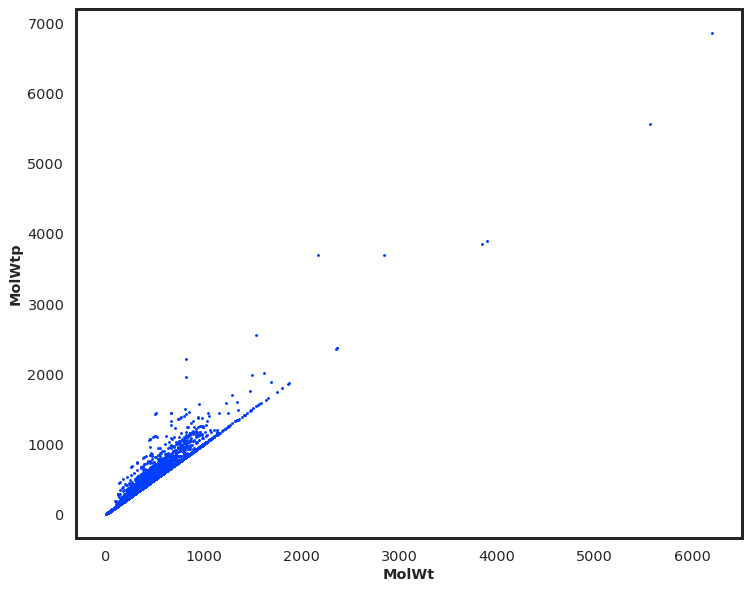

In [34]:
df.plot.scatter(x='MolWt', y='MolWtp',s=2)

In [35]:
import seaborn as sns

/tmp/ipykernel_64853/1372209034.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['MolWtdiff'].values[:])


<Axes: ylabel='Density'>

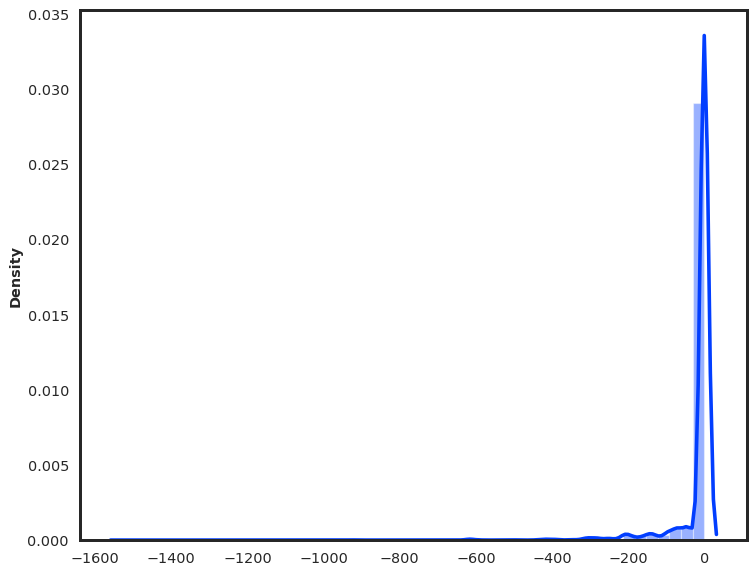

In [36]:
sns.distplot(df['MolWtdiff'].values[:])

In [37]:
df['gapdft']=df['lumo_dft']-df['homo_dft']
#dfzi.homo_z= dfzi.homo_z.apply(float)
#dfzi['gapz']=dfzi['lumo_z']-dfzi['homo_z']
#dfzi['gapmopac']=dfzi['lumo_mopac']-dfzi['homo_mopac']

In [40]:
df.homo_z = df.homo_z.apply(float)
df['gapz'] = df['lumo_z'] - df['homo_z']

In [41]:
df['gapmopac']=df['lumo_mopac']-df['homo_mopac']

/tmp/ipykernel_64853/3397837222.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['gapmopac'].values[:])


<Axes: ylabel='Density'>

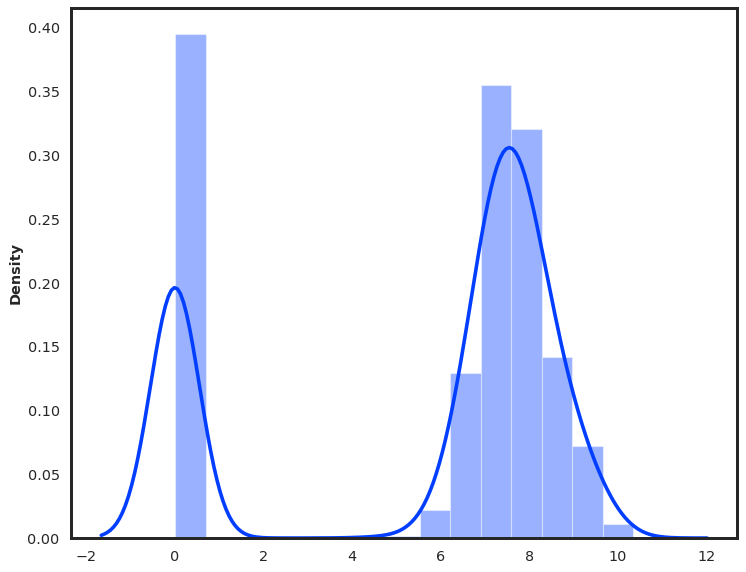

In [42]:
sns.distplot(df['gapmopac'].values[:])

In [42]:
df.to_pickle('../data/extended_db_Zindo_Nov_2019_V5_cannfp.pkl')
print('Column names: {}'.format(str(df.columns.tolist())))
print('Table Shape: {}'.format(df.shape))

Column names: ['smiles', 'inchikey', 'fpfail', 'smi_pre', 'smi_post', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent', 'nogood', 'nogoodp', 'mol', 'morganfps-b', 'morganfps-b8', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'molp', 'MolWt', 'MolWtp', 'MolWtdiff', 'gapdft', 'gapmopac']
Table Shape: (9870, 53)
